In [24]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'serif'

In [25]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [26]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'

def model(co2_constraint):
    network = pypsa.Network()
    hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                                '2015-12-31 23:00Z',
                                freq='h')

    network.set_snapshots(hours_in_2015.values)

    network.add("Bus",
                "electricity bus")
    # add load to the bus
    network.add("Load",
                "load",
                bus="electricity bus",
                p_set=df_elec[country].values)
    # CAPEX values for different technologies (in €/MW)
    offshoreWind_capex = 2.8e6
    onshoreWind_capex = 1.4e6
    solar_capex = 628e3
    ccgt_capex = 1.04e6
    nuclear_capex = 11.08e6

    # add the different carriers, only gas emits CO2
    network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
    network.add("Carrier", "onshorewind")
    network.add("Carrier", "solar")
    network.add("Carrier", "offshorewind")
    network.add("Carrier", "nuclear")

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex * (1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    network.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_onshorewind,
                marginal_cost = 0,
                p_max_pu = CF_windOnshore.values)

    # add offshore wind generator
    df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshore.index = pd.to_datetime(df_offshore.index)
    CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex *(1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    network.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_offshore,
                marginal_cost = 0,
                p_max_pu = CF_windOffshore.values)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
    network.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_solar,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)

    # add CCGT (Combine Cycle Gas Turbine) generator
    capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
    fuel_cost = 30.32 # in €/MWh_th
    efficiency = 0.5 # MWh_elec/MWh_th
    marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
    network.add("Generator",
                "CCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_CCGT,
                marginal_cost = marginal_cost_CCGT)

    # add nuclear generator
    capital_cost_nuclear = annuity(40,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
    fuel_cost = 6.2 # in €/MWh_th
    efficiency = 0.33 # MWh_elec/MWh_th
    marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
    network.add("Generator",
                "nuclear",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="nuclear",
                #p_nom_max=1000,
                capital_cost = capital_cost_nuclear,
                marginal_cost = marginal_cost_nuclear)
    
    # CO2 Constraint
    network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_constraint)
    network.optimize(solver_name='gurobi', solver_options={"LogToConsole": 0})

    return network



In [27]:
co2_limit=1000000 #tonCO2
network = model(co2_limit)


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.01it/s]
INFO:linopy.io: Writing time: 0.46s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-w_vpy055.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-w_vpy055.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 3.70e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [28]:
print(network.objective/1000000) #in 10^6 €

37043.57044104162


In [29]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    131.26932
dtype: float64


In [30]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     47035.679721
offshorewind        0.000000
solar           18129.914388
CCGT            19648.072501
nuclear         30427.143513
Name: p_nom_opt, dtype: float64

C:\Users\carlo\AppData\Local\Temp\ipykernel_55364\2499115036.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')


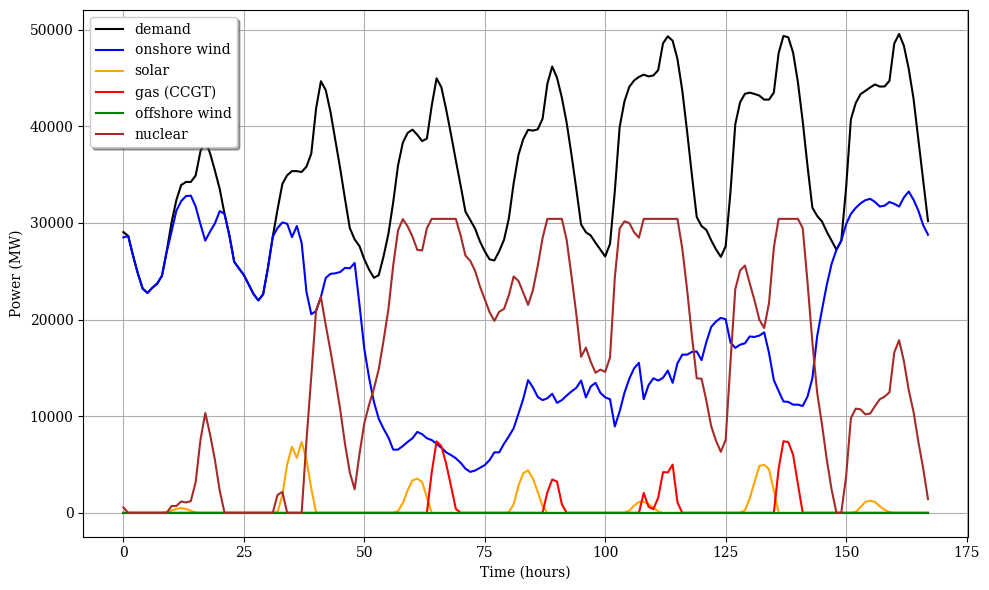

In [31]:
# Selection of plotted hours
num_hours_week = 24 * 7
hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')

demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

plt.figure(figsize=(10, 6))
plt.plot(demand, color='black', label='demand')
plt.plot(onshore_wind, color='blue', label='onshore wind')
plt.plot(solar, color='orange', label='solar')
plt.plot(gas_ccgt, color='red', label='gas (CCGT)')
plt.plot(offshore_wind, color='green', label='offshore wind')
plt.plot(nuclear, color='brown', label='nuclear')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
#plt.title('Energy Production and Demand')
# plt.xticks(rotation=45)
plt.grid(True)

# Improve x-axis ticks
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(3))
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()


Text(0.5, 1.07, 'Electricity mix')

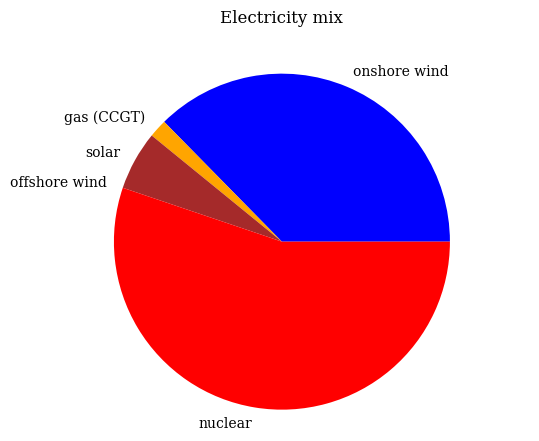

In [32]:
labels = ['onshore wind',
          'gas (CCGT)', 
          'solar',
          'offshore wind',
          'nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['nuclear'].sum()
]

colors=['blue', 'orange', 'brown', 'green', 'red']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

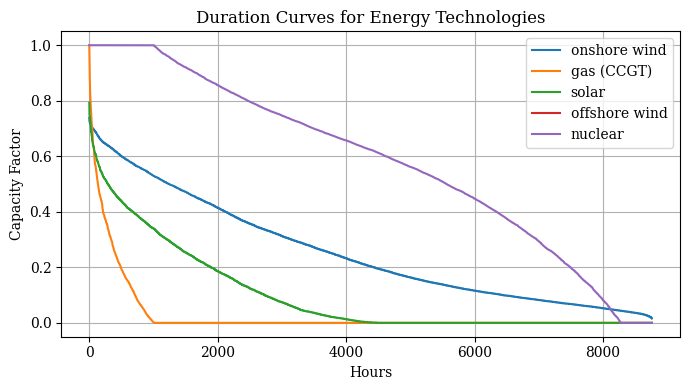

In [33]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT'],
    "solar": network.generators_t.p['solar'] / network.generators.p_nom_opt['solar'],
    "offshore wind": network.generators_t.p['offshorewind'] / network.generators.p_nom_opt['offshorewind'],
    "nuclear": network.generators_t.p['nuclear'] / network.generators.p_nom_opt['nuclear']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}

# Plotting the duration curves
plt.figure(figsize=(7, 4))
for tech, data in duration_curves.items():
    plt.plot(data, label=tech)

plt.title('Duration Curves for Energy Technologies')
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Define the CO2 constraint values for sensitivity analysis
co2_limits = [170e6, 140e6, 70e6, 35e6, 30e6, 20e6, 18e6, 15e6, 5e6, 1e6, 0.5e5, 1e4, 1e3, 1e2, 0]  # in tons of CO2

results = []

# Loop through each CO2 limit
for co2_limit in co2_limits:
    # Add or update the CO2 constraint in the network
    
    # Solve the network
    network = model(co2_limit) 

    capex = network.statistics.capex().div(1e6)  # million €/y
    opex = network.statistics.opex().div(1e6) # million €/y
    tsc = capex + opex
    tsc = tsc.div(1e6)  # million €/y  
    co2_price = -network.global_constraints.mu['co2_limit']

    # Extract the optimized generator capacities
    results.append({
        "CO2_Limit": co2_limit,
        "Capacity_MW": network.generators.p_nom_opt,
        "CO2_Price": co2_price,
        "System_capex": capex,  # million €/y
        "System_opex": opex,  # million €/y
        "System_cost": tsc,  # million €/y
    })

# Save the results to a CSV file for further analysis
# results.to_csv("sensitivity_analysis_results.csv", index=False)

# Display the results
print(results)

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.21it/s]
INFO:linopy.io: Writing time: 0.43s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-jtvwdbnc.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-jtvwdbnc.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 36.29it/s]
INFO:linopy.io: Writing time: 0.43s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ha4rfrg3.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ha4rfrg3.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.11it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-il1ioqr9.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-il1ioqr9.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 32.08it/s]
INFO:linopy.io: Writing time: 0.43s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-k4rdnrtx.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-k4rdnrtx.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 38.61it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-are4hy1_.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-are4hy1_.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.09e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.88it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-yy8bmmbp.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-yy8bmmbp.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.23e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 36.64it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-tt39hc2j.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-tt39hc2j.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 27.21it/s]
INFO:linopy.io: Writing time: 0.42s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ti10tbc9.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ti10tbc9.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.30it/s]
INFO:linopy.io: Writing time: 0.39s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-s4n3ftlr.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-s4n3ftlr.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 3.07e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 34.00it/s]
INFO:linopy.io: Writing time: 0.39s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-0pkhgkm2.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-0pkhgkm2.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 3.70e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 36.37it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-iyqjxj1u.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-iyqjxj1u.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 4.47e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 37.64it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-1gqmxziu.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-1gqmxziu.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 4.68e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.97it/s]
INFO:linopy.io: Writing time: 0.41s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-5ugnwpnk.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-5ugnwpnk.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 4.82e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 34.79it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-4nfhb1no.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-4nfhb1no.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 4.87e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.43it/s]
INFO:linopy.io: Writing time: 0.4s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-grncceur.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-grncceur.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 96366 rows, 43805 columns, 179719 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 179719 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 4.89e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


[{'CO2_Limit': 170000000.0, 'Capacity_MW': Generator
onshorewind     49966.804979
offshorewind        0.000000
solar               0.000000
CCGT            49928.659751
nuclear             0.000000
Name: p_nom_opt, dtype: float64, 'CO2_Price': np.float64(-0.0), 'System_capex': component  carrier    
Generator  gas            4242.131505
           onshorewind    6182.830781
dtype: float64, 'System_opex': component  carrier
Generator  gas        10347.969413
Name: generators, dtype: float64, 'System_cost': component  carrier    
Generator  gas            0.01459
           onshorewind        NaN
dtype: float64}, {'CO2_Limit': 140000000.0, 'Capacity_MW': Generator
onshorewind     49966.804979
offshorewind        0.000000
solar               0.000000
CCGT            49928.659751
nuclear             0.000000
Name: p_nom_opt, dtype: float64, 'CO2_Price': np.float64(-0.0), 'System_capex': component  carrier    
Generator  gas            4242.131505
           onshorewind    6182.830781
dtype

In [35]:
total_capacity = [entry["Capacity_MW"].sum() for entry in results]

solar = [entry["Capacity_MW"]["solar"] / total for entry, total in zip(results, total_capacity)]
onshorewind = [entry["Capacity_MW"]["onshorewind"] / total for entry, total in zip(results, total_capacity)]
ccgt = [entry["Capacity_MW"]["CCGT"] / total for entry, total in zip(results, total_capacity)]
offshorewind = [entry["Capacity_MW"]["offshorewind"] / total for entry, total in zip(results, total_capacity)]
nuclear = [entry["Capacity_MW"]["nuclear"] / total for entry, total in zip(results, total_capacity)]

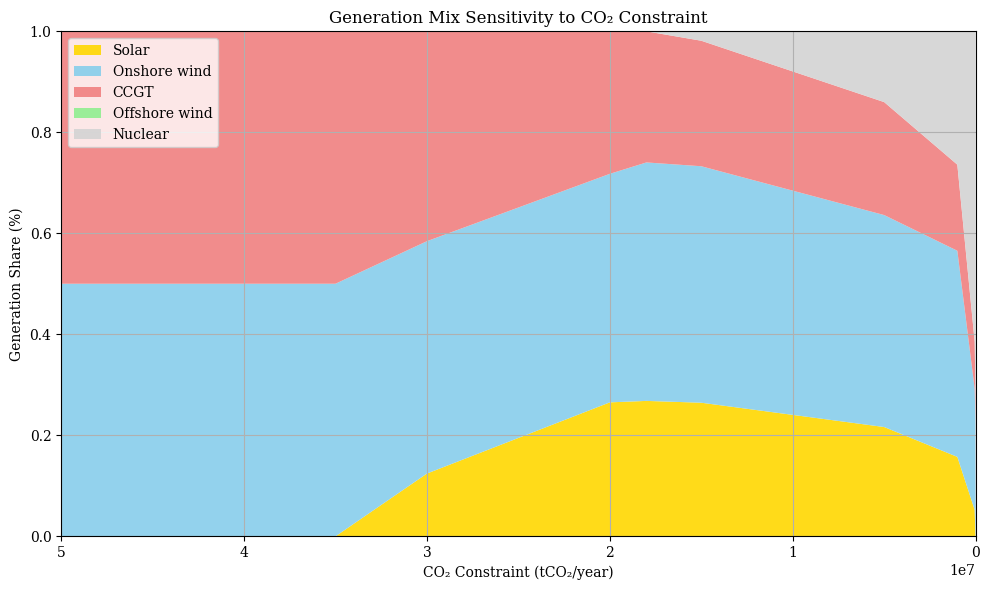

In [45]:


# Plot: Generation mix as a function of CO₂ constraint
plt.figure(figsize=(10, 6))
plt.stackplot(co2_limits, solar, onshorewind, ccgt, offshorewind, nuclear,
              labels=['Solar', 'Onshore wind', 'CCGT', 'Offshore wind', 'Nuclear'],
              colors=['gold', 'skyblue', 'lightcoral', 'lightgreen', 'lightgrey'],
              alpha=0.9)

plt.xlabel('CO₂ Constraint (tCO₂/year)')
plt.ylabel('Generation Share (%)')
plt.title('Generation Mix Sensitivity to CO₂ Constraint')
plt.xlim(0,50e6)
plt.ylim(0,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.gca().invert_xaxis()  # So tighter constraint appears on the right
plt.tight_layout()


In [ ]:
for result in results:
    print(result["System_opex"])

component  carrier
Generator  gas        10347.969413
Name: generators, dtype: float64
component  carrier
Generator  gas        10347.969413
Name: generators, dtype: float64
component  carrier
Generator  gas        10347.969413
Name: generators, dtype: float64
component  carrier
Generator  gas        10347.969413
Name: generators, dtype: float64
component  carrier
Generator  gas        9010.401189
Name: generators, dtype: float64
component  carrier
Generator  gas        6006.934126
Name: generators, dtype: float64
component  carrier
Generator  gas        5406.240713
Name: generators, dtype: float64
component  carrier
Generator  gas        4505.200594
           nuclear     337.363261
Name: generators, dtype: float64
component  carrier
Generator  gas        1501.733531
           nuclear    2048.411037
Name: generators, dtype: float64
component  carrier
Generator  gas         300.346706
           nuclear    2926.380912
Name: generators, dtype: float64
component  carrier
Generator  gas 

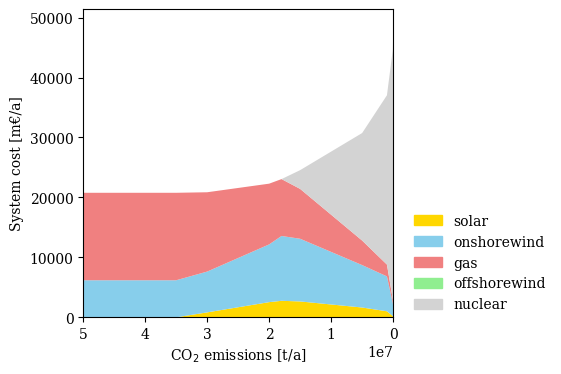

In [86]:
system_costs = {}
for result in results:
    # Making sure that there is no NaN values, although in some scenarios some tecs dont have opex or capex values
    capex = result["System_capex"].droplevel(0).reindex(result["System_capex"].index.levels[1], fill_value=0)
    opex = result["System_opex"].droplevel(0).reindex(result["System_capex"].index.levels[1], fill_value=0)
    
    # Add the costs to the dictionary
    system_costs[result["CO2_Limit"]] = capex + opex

labels = ['solar', 'onshorewind', 'gas', 'offshorewind', 'nuclear']  # Asegúrate de usar los nombres exactos
colors = ['gold', 'skyblue', 'lightcoral', 'lightgreen', 'lightgrey']

df = pd.DataFrame(system_costs).T 

df = df[labels]
df.plot.area(
    stacked=True,
    linewidth=0,
    color=colors,
    figsize=(4, 4),
    xlim = (0,50e6),
    xlabel=r"CO$_2$ emissions [t/a]",
    ylabel="System cost [m€/a]",
    #ylim=(0, 4),
)
from matplotlib.patches import Patch
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=legend_patches, frameon=False, loc=(1.05, 0))
plt.gca().invert_xaxis()

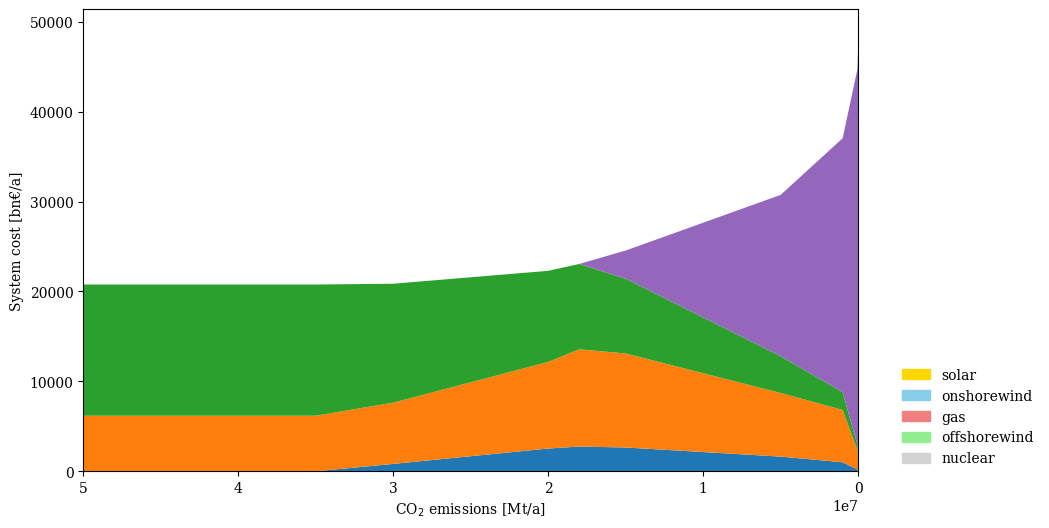

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarse que los datos están correctamente poblados en df
# Asumiendo que 'df' ya está creado y contiene las columnas correctas con datos de costos del sistema

labels = ['solar', 'onshorewind', 'gas', 'offshorewind', 'nuclear']
colors = ['gold', 'skyblue', 'lightcoral', 'lightgreen', 'lightgrey']

# Graficar el área
ax = df.plot.area(stacked=True, linewidth=0, figsize=(10, 6), xlim=(0, 50e6),
                  xlabel=r"CO$_2$ emissions [Mt/a]", ylabel="System cost [bn€/a]")

# Invertir el eje x
plt.gca().invert_xaxis()

# Crear una leyenda personalizada con los colores correspondientes
from matplotlib.patches import Patch
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=legend_patches, frameon=False, loc=(1.05, 0))

plt.show()
